In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
from scipy import stats


In [2]:
DATA_DIR = "./"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

In [3]:
def LoadData(data_filename, data_dir):
    '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
    return pd.read_csv(os.path.join(data_dir, data_filename))  

In [4]:
df_sms = LoadData(DATA_FILENAMES["sms"], DATA_DIR)
print("\nsms\n", df_sms.head())


sms
    timestamp  sender  recipient
0         18     370        512
1         37     512        370
2        126     370        512
3        134       0        512
4        312     137        136


### SMS analysis

In [5]:
DF_sms = df_sms
DF_sms["hour"] = DF_sms["timestamp"]// (3600) + 1
DF_sms["day"] = DF_sms["timestamp"]// (3600*24) + 1
DF_sms["week"] = DF_sms["timestamp"]// (3600*24*7) + 1
DF_sms["weight"] = np.ones(len(DF_sms))


DF_sms

,timestamp,sender,recipient,hour,day,week,weight
0,18,370,512,1,1,1,1.0
1,37,512,370,1,1,1,1.0
2,126,370,512,1,1,1,1.0
3,134,0,512,1,1,1,1.0
4,312,137,136,1,1,1,1.0
...,...,...,...,...,...,...,...
24328,2415198,238,26,671,28,4,1.0
24329,2416413,137,136,672,28,4,1.0
24330,2417238,136,137,672,28,4,1.0
24331,2417633,323,392,672,28,4,1.0


### DEGREE IN OUT

### WEEKLY 

Text(0.5, 0.98, 'SMS weekly distribution network')

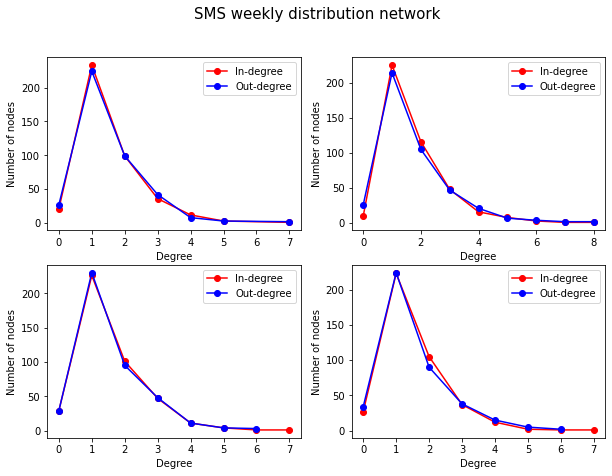

In [6]:
sms_week =  DF_sms[["sender","recipient","week","weight"]].groupby(["sender","recipient","week"]).sum().reset_index()
sms_week = sms_week.sort_values(by=['week']).reset_index(drop=True)
sms_week


fig, ax = plt.subplots(2,2,figsize=(10,7))

for i,a in enumerate(ax.flatten()):
    app = sms_week[sms_week["week"] == i+1]
    G_sms = nx.from_pandas_edgelist(app,
                    source='sender',target='recipient',edge_attr='weight', create_using=nx.DiGraph())

    nnodes = G_sms.number_of_nodes()
    degrees_in = [d for n, d in G_sms.in_degree()]
    degrees_out = [d for n, d in G_sms.out_degree()]
    avrg_degree_in = sum(degrees_in) / float(nnodes)
    avrg_degree_out = sum(degrees_out) / float(nnodes)

    in_values = sorted(set(degrees_in))
    in_hist = [degrees_in.count(x) for x in in_values]
    out_values = sorted(set(degrees_out))
    out_hist = [degrees_out.count(x) for x in out_values]


    a.plot(in_values,in_hist,'ro-') # in-degree
    a.plot(out_values,out_hist,'bo-') # out-degree
    a.legend(['In-degree','Out-degree'])
    a.set_xlabel('Degree')
    a.set_ylabel('Number of nodes')
fig.suptitle('SMS weekly distribution network', fontsize=15)

### TOTAL

In [7]:
sms_total =  DF_sms[["sender","recipient","weight"]].groupby(["sender","recipient"]).sum().reset_index()
sms_total

,sender,recipient,weight
0,0,208,1.0
1,0,512,61.0
2,1,345,2.0
3,3,49,41.0
4,3,217,3.0
...,...,...,...
1298,845,256,1.0
1299,846,191,1.0
1300,846,291,10.0
1301,846,374,2.0


Mean degree : 2.2940140845070425


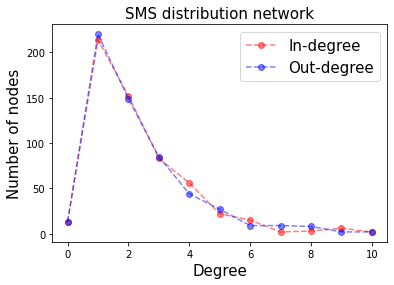

In [8]:
G_sms = nx.from_pandas_edgelist(sms_total,
                source='sender',target='recipient',edge_attr='weight', create_using=nx.DiGraph())

nnodes = G_sms.number_of_nodes()
degrees_in = [d for n, d in G_sms.in_degree()]
degrees_out = [d for n, d in G_sms.out_degree()]
avrg_degree_in = np.mean(degrees_in) 
avrg_degree_out = np.mean(degrees_out)

in_values = sorted(set(degrees_in))
in_hist = [degrees_in.count(x) for x in in_values]
out_values = sorted(set(degrees_out))
out_hist = [degrees_out.count(x) for x in out_values]


#plt.plot(in_values,sum(in_hist)-np.cumsum(in_hist),'ro--') # in-degree
#plt.plot(out_values,sum(out_hist)-np.cumsum(out_hist),'bo--') # out-degree

plt.plot(in_values,in_hist,'ro--',alpha=0.5) # in-degree
plt.plot(out_values,out_hist,'bo--',alpha=0.5) # out-degree
plt.legend(['In-degree','Out-degree'],fontsize=15)
plt.xlabel('Degree',fontsize=15)
plt.ylabel('Number of nodes',fontsize=15)
plt.title('SMS distribution network', fontsize=15)

print('Mean degree :',avrg_degree_in)

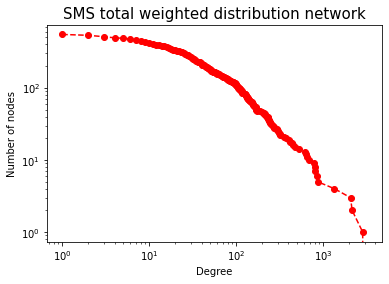

In [9]:
G_sms = nx.from_pandas_edgelist(sms_total,
                source='sender',target='recipient',edge_attr='weight', create_using=nx.DiGraph())

nnodes = G_sms.number_of_nodes()
degrees_in = [d for n, d in G_sms.degree(weight = 'weight')]
avrg_degree_in = sum(degrees_in) / float(nnodes)

in_values = sorted(set(degrees_in))
in_hist = [degrees_in.count(x) for x in in_values]

plt.plot(in_values,sum(in_hist) - np.cumsum(in_hist),'ro--') # in-degree
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('SMS total weighted distribution network', fontsize=15)
plt.xscale('log')
plt.yscale('log')

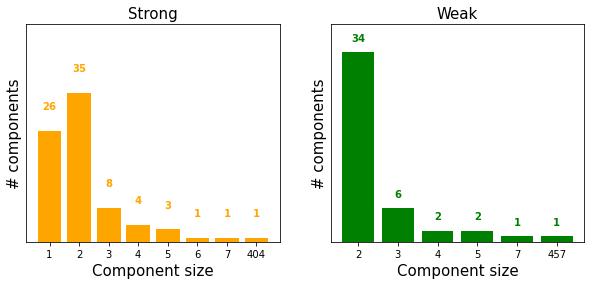

In [10]:
fig, ax = plt.subplots(1,2,figsize=(10,4))


strong_com = list(nx.strongly_connected_components(G_sms))
weak_com = list(nx.weakly_connected_components(G_sms))
strong = []
weak = []
for c in strong_com:
    strong.append(len(c))
for c in weak_com:
    weak.append(len(c))
x,y = np.unique(strong,return_counts=True)  
ax[0].bar([str(i) for i in x],y,color='orange')
ax[0].set_title("Strong",fontsize=15)
ax[0].set_xlabel("Component size",fontsize=15)
ax[0].set_ylabel("# components",fontsize=15)
ax[0].set_yticks([])
ax[0].set_ylim(0,max(y)+16)
for i, v in enumerate(y):
    ax[0].text(i ,v + 5, str(v), color='orange' , fontweight='bold',ha='center')

x,y = np.unique(weak,return_counts=True)  
ax[1].bar([str(i) for i in x],y,color='green')
ax[1].set_title("Weak",fontsize=15)
ax[1].set_xlabel("Component size",fontsize=15)
ax[1].set_ylabel("# components",fontsize=15)
ax[1].set_yticks([])
ax[1].set_ylim(0,max(y)+5)
for i, v in enumerate(y):
    ax[1].text(i ,v + 2, str(v), color='green' , fontweight='bold',ha='center')


## DEGREE CENTRALITY

In [10]:
deg = nx.degree_centrality(G_sms)
sorted(deg,key=deg.get,reverse=True)[:10]

[176, 221, 100, 485, 371, 401, 457, 13, 268, 598]

In [11]:
in_deg = nx.in_degree_centrality(G_sms)
sorted(in_deg,key=in_deg.get,reverse=True)[:10]

[176, 221, 100, 485, 371, 401, 457, 268, 13, 52]

In [12]:
out_deg = nx.out_degree_centrality(G_sms)
sorted(out_deg,key=out_deg.get,reverse=True)[:10]

[176, 221, 100, 485, 512, 4, 13, 371, 401, 457]

## CLOSENESS CENTRALITY

In [13]:
clo = nx.closeness_centrality(G_sms)
sorted(clo,key=clo.get,reverse=True)[:10]

[176, 221, 401, 4, 52, 472, 611, 36, 268, 324]

## SMS TRAFFIC
1 domenica 

2 lunedi 

3 ...



In [132]:
traff = df_sms[["hour","weight"]].groupby("hour").sum().reset_index()
traff["hour"] -= 1

traff

,hour,weight
0,0,34.0
1,1,22.0
2,2,7.0
3,3,14.0
4,4,1.0
...,...,...
585,667,46.0
586,668,8.0
587,669,37.0
588,670,19.0


In [133]:
x = traff.hour.values
y = traff.weight.values

X = []
Y = []
for i in range(672):
    X.append(i)
    if i in x:
        Y.append(y[x==i][0])
    else:
        Y.append(0)

In [134]:
days = {
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday', 
    4: 'Thursday', 
    5: 'Friday', 
    6: 'Saturday'
}

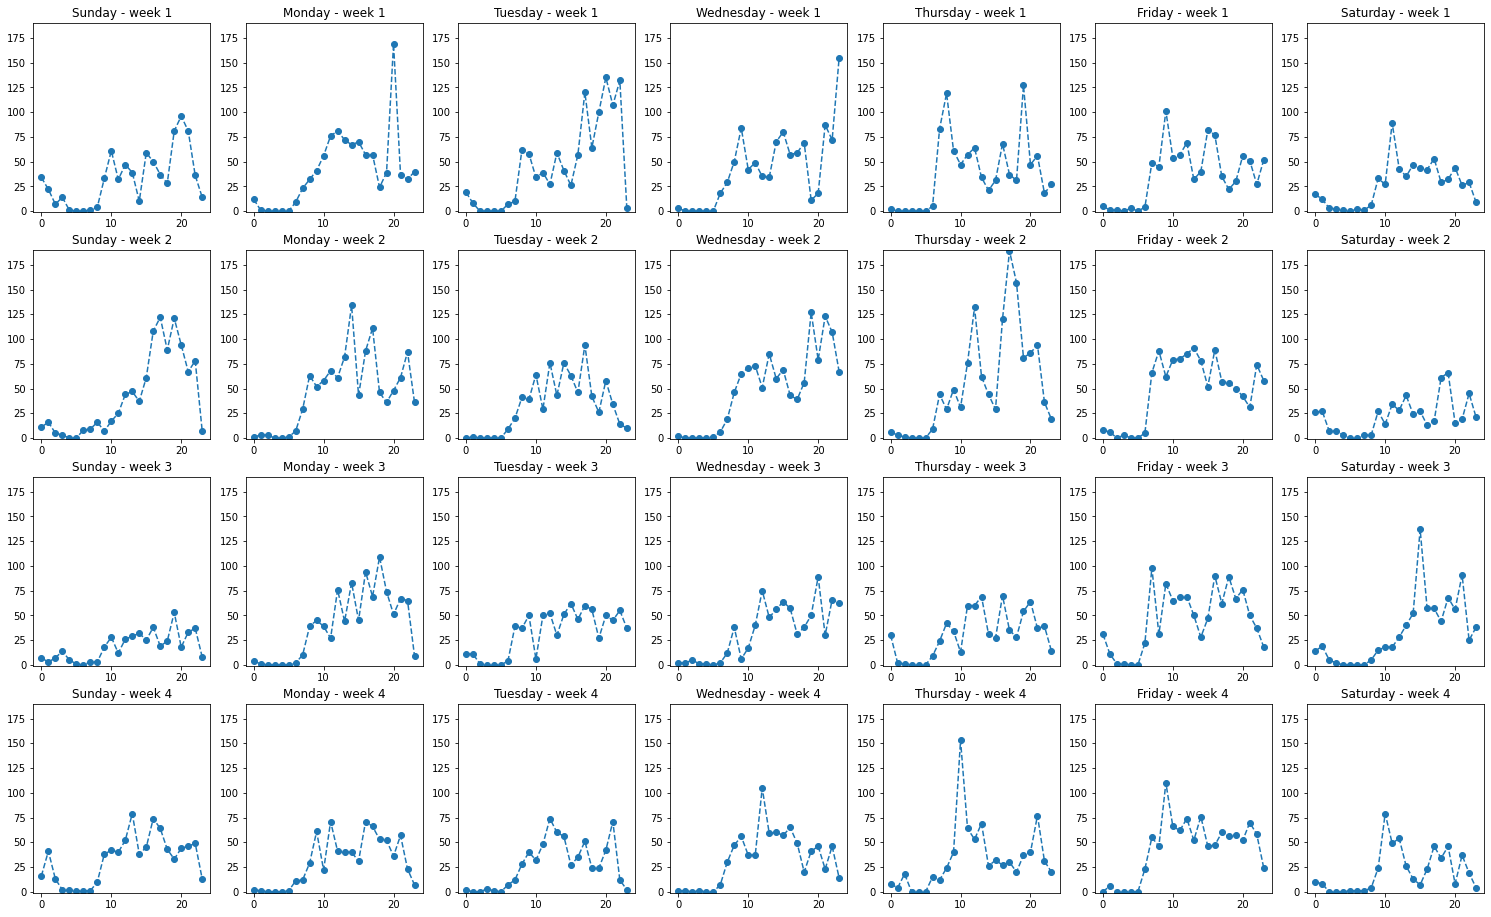

In [135]:
fig, ax = plt.subplots(4,7,figsize=(26,16))


for i,g in enumerate(range(7*4)):
    x = i//7
    y = i%7
    ax[x,y].plot(X[:24],Y[24*(g):24*(g+1)],'o--')
    ax[x,y].set_title(days[i%7] + ' - week ' + str(x+1))
    ax[x,y].set_ylim(-1,max(Y)+1)

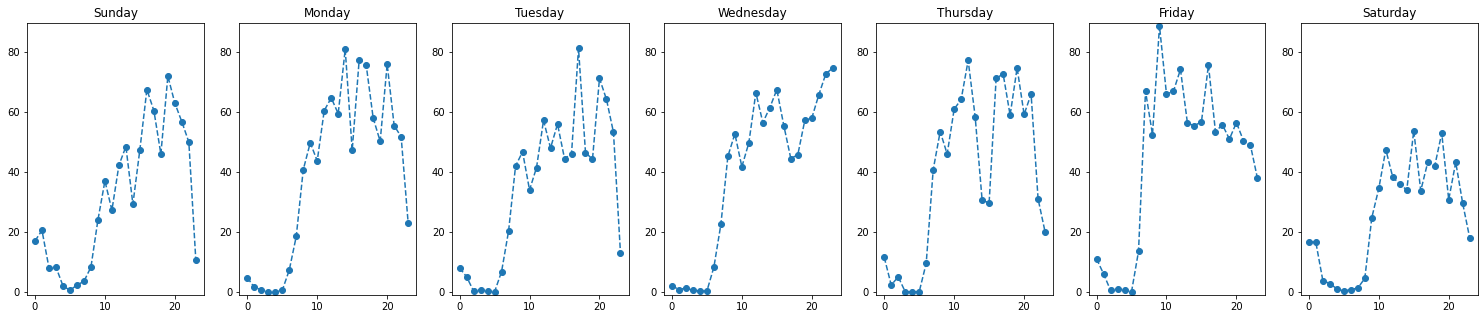

In [136]:
day_mean = [[] for i in range(7)]

for i,g in enumerate(range(7*4)):
    y = i%7
    day_mean[y].append(Y[24*(g):24*(g+1)])

    
day_mean = np.array(day_mean).mean(axis=1)

fig, ax = plt.subplots(1,7,figsize=(26,5))


for i,k in enumerate(day_mean):
    ax[i].plot(k,'o--')
    ax[i].set_title(days[i%7])
    ax[i].set_ylim(-1,1+np.max(day_mean))

In [137]:
sms_traf_comp = day_mean.copy()

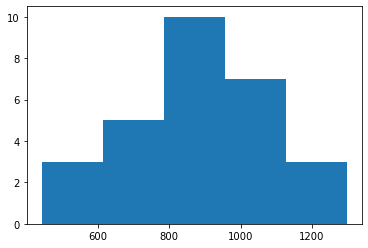

In [76]:
traff = df_sms[["day","weight"]].groupby("day").sum().reset_index()

_ = plt.hist(traff.weight,bins=5)

### ASSORTATIVITY

Text(10, 8, 'SLOPE: $0.14\\pm 0.02> 0$')

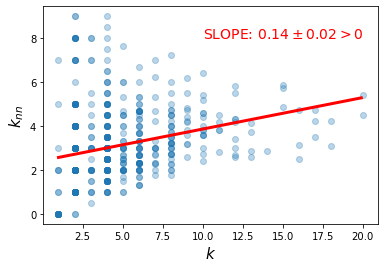

In [282]:
G_sms = nx.from_pandas_edgelist(sms_total,
                source='sender',target='recipient',edge_attr='weight', create_using=nx.DiGraph())
y = nx.average_neighbor_degree(G_sms)
x = nx.degree(G_sms)

X = []
Y = []

for k in y.keys():
    X.append(x[k])
    Y.append(y[k])
    
    
res = stats.linregress(X, Y)
x = np.arange(min(X),max(X),0.1)

plt.plot(X,Y,'o',alpha=0.3)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k_{nn}$',fontsize=15)

plt.plot(x,x*res.slope + res.intercept,'r-',linewidth =3)
txt = r'SLOPE: $'+str(res.slope)[:4] + '\pm '+ str(res.stderr)[:4] +'> 0$'
plt.text(10,8,txt,fontsize=14 ,color= 'red')


### RANKING SMS

In [32]:
sms_total[['sender','weight']].groupby('sender').sum().sort_values(by="weight",ascending=False).head(10)

,weight
sender,
617,1585.0
279,1448.0
176,1107.0
578,1003.0
481,797.0
21,486.0
91,428.0
90,395.0
512,357.0


In [125]:
df1 = sms_total.copy()
df1['sender'] = sms_total['recipient']
df1['recipient'] = sms_total['sender']


In [131]:
app = pd.concat([df1,sms_total],ignore_index=True)
app = app.groupby(['sender','recipient']).sum().reset_index().sort_values(by="weight",ascending=False)

app.head(6)

,sender,recipient,weight
1186,617,279,2860.0
577,279,617,2860.0
1125,578,176,1764.0
376,176,578,1764.0
954,481,296,864.0
608,296,481,864.0


## CALLS

In [38]:
df_calls = LoadData(DATA_FILENAMES["calls"], DATA_DIR)
DF_calls = df_calls
DF_calls["hour"] = DF_calls["timestamp"]// (3600)
DF_calls["day"] = DF_calls["timestamp"]// (3600*24) + 1
DF_calls["week"] = DF_calls["timestamp"]// (3600*24*7) + 1


DF_calls = DF_calls[DF_calls["duration"] != -1]
DF_calls

,timestamp,caller,callee,duration,hour,day,week
0,184,300,301,121,0,1,1
1,3920,512,299,670,1,1,1
2,5623,301,300,504,1,1,1
4,15466,512,0,5,4,1,1
5,15497,512,0,28,4,1,1
...,...,...,...,...,...,...,...
3595,2414934,706,401,78,670,28,4
3596,2415585,218,382,48,670,28,4
3597,2416059,561,631,13,671,28,4
3598,2416368,323,392,4,671,28,4


### DEGREE IN OUT

### WEEKLY 

Text(0.5, 0.98, 'SMS weekly distribution network')

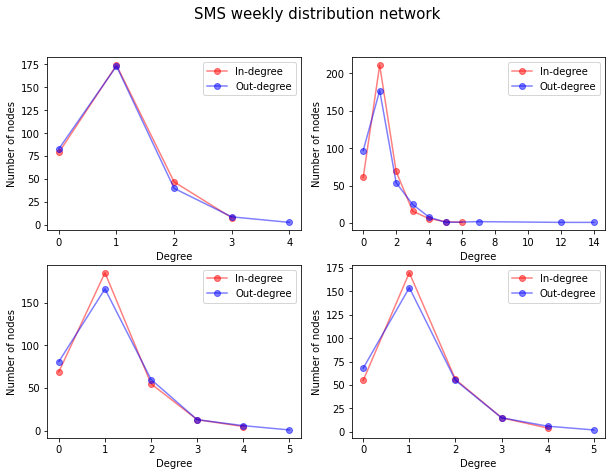

In [39]:
sms_week =  DF_calls[["caller","callee","week","duration"]].groupby(["caller","callee","week"]).sum().reset_index()
sms_week = sms_week.sort_values(by=['week']).reset_index(drop=True)
sms_week


fig, ax = plt.subplots(2,2,figsize=(10,7))

for i,a in enumerate(ax.flatten()):
    app = sms_week[sms_week["week"] == i+1]
    G_sms = nx.from_pandas_edgelist(app,
                    source='caller',target='callee',edge_attr='duration', create_using=nx.DiGraph())

    nnodes = G_sms.number_of_nodes()
    degrees_in = [d for n, d in G_sms.in_degree()]
    degrees_out = [d for n, d in G_sms.out_degree()]
    avrg_degree_in = sum(degrees_in) / float(nnodes)
    avrg_degree_out = sum(degrees_out) / float(nnodes)

    in_values = sorted(set(degrees_in))
    in_hist = [degrees_in.count(x) for x in in_values]
    out_values = sorted(set(degrees_out))
    out_hist = [degrees_out.count(x) for x in out_values]


    a.plot(in_values,in_hist,'ro-',alpha=.5) # in-degree
    a.plot(out_values,out_hist,'bo-',alpha=.5) # out-degree
    a.legend(['In-degree','Out-degree'])
    a.set_xlabel('Degree')
    a.set_ylabel('Number of nodes')
fig.suptitle('SMS weekly distribution network', fontsize=15)

### TOTAL

In [40]:
calls_total =  DF_calls[["caller","callee","duration"]].groupby(["caller","callee"]).sum().reset_index()
calls_total

,caller,callee,duration
0,0,208,180
1,0,512,3
2,3,48,34
3,3,49,25
4,3,357,104
...,...,...,...
876,830,257,4
877,845,228,29
878,845,256,48
879,846,191,23


Mean degree :  1.678095238095238


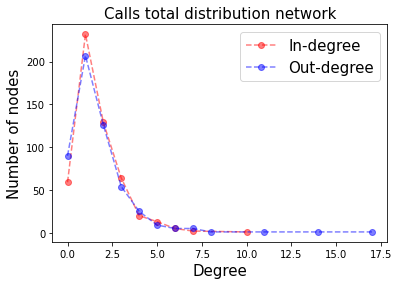

In [321]:
G_calls = nx.from_pandas_edgelist(calls_total,
                source='caller',target='callee',edge_attr='duration', create_using=nx.DiGraph())

nnodes = G_calls.number_of_nodes()
degrees_in = [d for n, d in G_calls.in_degree()]
degrees_out = [d for n, d in G_calls.out_degree()]
avrg_degree_in = sum(degrees_in) / float(nnodes)
avrg_degree_out = sum(degrees_out) / float(nnodes)

in_values = sorted(set(degrees_in))
in_hist = [degrees_in.count(x) for x in in_values]
out_values = sorted(set(degrees_out))
out_hist = [degrees_out.count(x) for x in out_values]


#plt.plot(in_values,sum(in_hist)-np.cumsum(in_hist),'ro--') # in-degree
#plt.plot(out_values,sum(out_hist)-np.cumsum(out_hist),'bo--') # out-degree

plt.plot(in_values,in_hist,'ro--',alpha=.5) # in-degree
plt.plot(out_values,out_hist,'bo--',alpha=.5) # out-degree
plt.legend(['In-degree','Out-degree'], fontsize=15)
plt.xlabel('Degree', fontsize=15)
plt.ylabel('Number of nodes', fontsize=15)
plt.title('Calls total distribution network', fontsize=15)
print('Mean degree : ', avrg_degree_in)


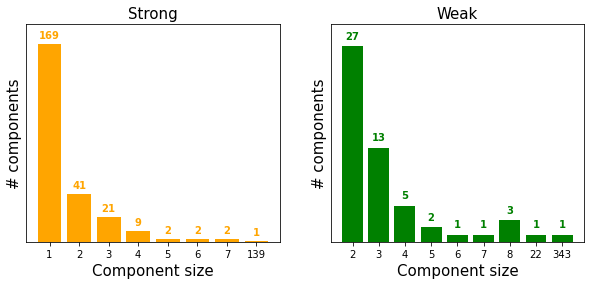

In [359]:
fig, ax = plt.subplots(1,2,figsize=(10,4))


strong_com = list(nx.strongly_connected_components(G_calls))
weak_com = list(nx.weakly_connected_components(G_calls))

strong = []
weak = []
for c in strong_com:
    strong.append(len(c))
for c in weak_com:
    weak.append(len(c))
x,y = np.unique(strong,return_counts=True)  
ax[0].bar([str(i) for i in x],y,color='orange')
ax[0].set_title("Strong",fontsize=15)
ax[0].set_xlabel("Component size",fontsize=15)
ax[0].set_ylabel("# components",fontsize=15)
ax[0].set_yticks([])
ax[0].set_ylim(0,max(y)+17)
for i, v in enumerate(y):
    ax[0].text(i ,v + 5, str(v), color='orange' , fontweight='bold', ha='center')

x,y = np.unique(weak,return_counts=True)  
ax[1].bar([str(i) for i in x],y,color='green')
ax[1].set_title("Weak",fontsize=15)
ax[1].set_xlabel("Component size",fontsize=15)
ax[1].set_ylabel("# components",fontsize=15)
ax[1].set_yticks([])
ax[1].set_ylim(0,max(y)+3)
for i, v in enumerate(y):
    ax[1].text(i,v + 1, str(v), color='green' , fontweight='bold', ha='center')


## DEGREE CENTRALITY

In [57]:
deg = nx.degree_centrality(G_calls)
sorted(deg,key=deg.get,reverse=True)[:10]

[221, 263, 485, 401, 268, 69, 52, 49, 4, 13]

In [58]:
in_deg = nx.in_degree_centrality(G_calls)
sorted(in_deg,key=in_deg.get,reverse=True)[:10]

[401, 208, 268, 49, 485, 69, 682, 342, 4, 221]

In [59]:
out_deg = nx.out_degree_centrality(G_calls)
sorted(out_deg,key=out_deg.get,reverse=True)[:10]

[221, 263, 485, 52, 13, 401, 88, 677, 262, 4]

### ASSORTATIVITY

Text(10, 8, 'SLOPE: $0.25\\pm 0.02> 0$')

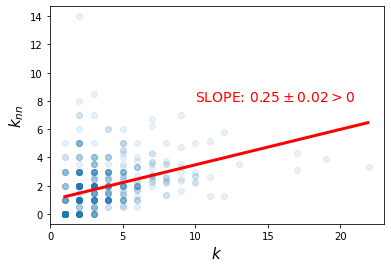

In [277]:
G_calls = nx.from_pandas_edgelist(calls_total,
                source='caller',target='callee', create_using=nx.DiGraph())

y = nx.average_neighbor_degree(G_calls)
x = nx.degree(G_calls)

X = []
Y = []

for k in y.keys():
    X.append(x[k])
    Y.append(y[k])
    
    
res = stats.linregress(X, Y)
x = np.arange(min(X),max(X),0.1)

plt.plot(X,Y,'o',alpha=0.1)
plt.xlabel(r'$k$',fontsize=15)
plt.ylabel(r'$k_{nn}$',fontsize=15)

plt.plot(x,x*res.slope + res.intercept,'r-',linewidth =3)
txt = r'SLOPE: $'+str(res.slope)[:4] + '\pm '+ str(res.stderr)[:4] +'> 0$'
plt.text(10,8,txt,fontsize=14 ,color= 'red')



### RANKING CALLS

In [60]:
calls_total.sort_values(by="duration",ascending=False).head(10)

,caller,callee,duration
188,136,137,8353
751,623,651,8060
659,522,436,5544
537,420,495,4850
635,495,420,4432
609,480,556,3862
711,578,289,3598
120,90,91,3513
60,39,622,3192
470,358,90,3086


In [61]:
df1 = calls_total.copy()
df1['caller'] = calls_total['callee']
df1['callee'] = calls_total['caller']


In [62]:
pd.concat([df1,calls_total],ignore_index=True).sort_values(by="duration",ascending=False).head(10)

,caller,callee,duration
188,137,136,8353
1069,136,137,8353
1632,623,651,8060
751,651,623,8060
659,436,522,5544
1540,522,436,5544
1418,420,495,4850
537,495,420,4850
635,420,495,4432
1516,495,420,4432


### CALLS TRAFFIC

In [63]:
DF_calls["weight"] = np.ones(len(DF_calls))

DF_calls

/tmp/ipykernel_8001/1319490097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_calls["weight"] = np.ones(len(DF_calls))


,timestamp,caller,callee,duration,hour,day,week,weight
0,184,300,301,121,0,1,1,1.0
1,3920,512,299,670,1,1,1,1.0
2,5623,301,300,504,1,1,1,1.0
4,15466,512,0,5,4,1,1,1.0
5,15497,512,0,28,4,1,1,1.0
...,...,...,...,...,...,...,...,...
3595,2414934,706,401,78,670,28,4,1.0
3596,2415585,218,382,48,670,28,4,1.0
3597,2416059,561,631,13,671,28,4,1.0
3598,2416368,323,392,4,671,28,4,1.0


In [138]:
traff = DF_calls[["hour","weight"]].groupby("hour").sum().reset_index()

traff

,hour,weight
0,0,1.0
1,1,2.0
2,4,2.0
3,7,1.0
4,8,1.0
...,...,...
497,667,3.0
498,668,12.0
499,669,6.0
500,670,4.0


In [139]:
x = traff.hour.values
y = traff.weight.values

X = []
Y = []
for i in range(672):
    X.append(i)
    if i in x:
        Y.append(y[x==i][0])
    else:
        Y.append(0)

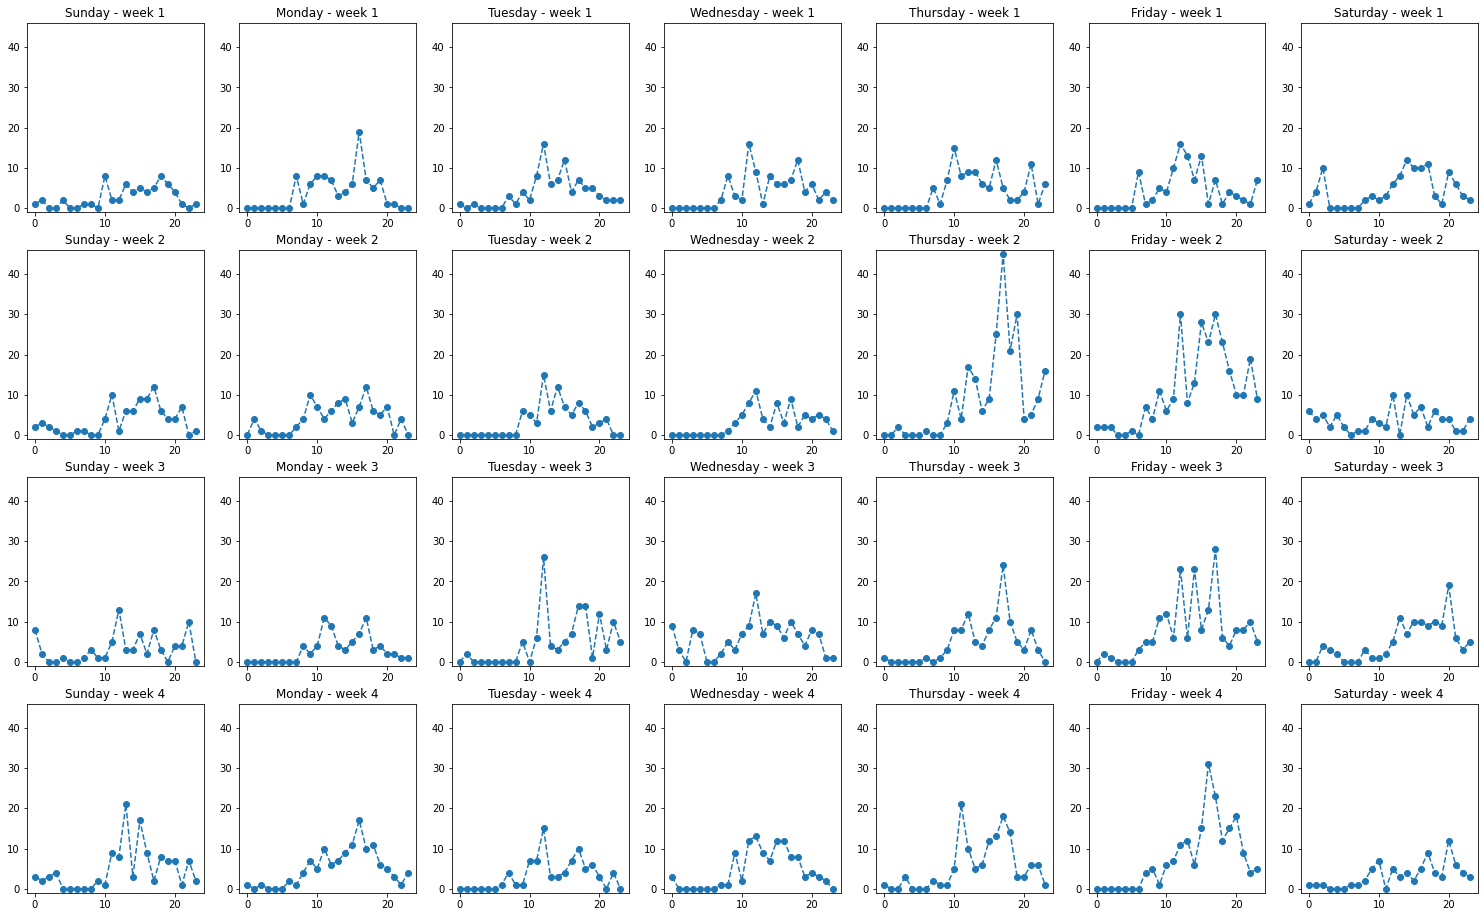

In [140]:
fig, ax = plt.subplots(4,7,figsize=(26,16))


for i,g in enumerate(range(7*4)):
    x = i//7
    y = i%7
    ax[x,y].plot(X[:24],Y[24*(g):24*(g+1)],'o--')
    ax[x,y].set_title(days[i%7] + ' - week ' + str(x+1))
    ax[x,y].set_ylim(-1,max(Y)+1)

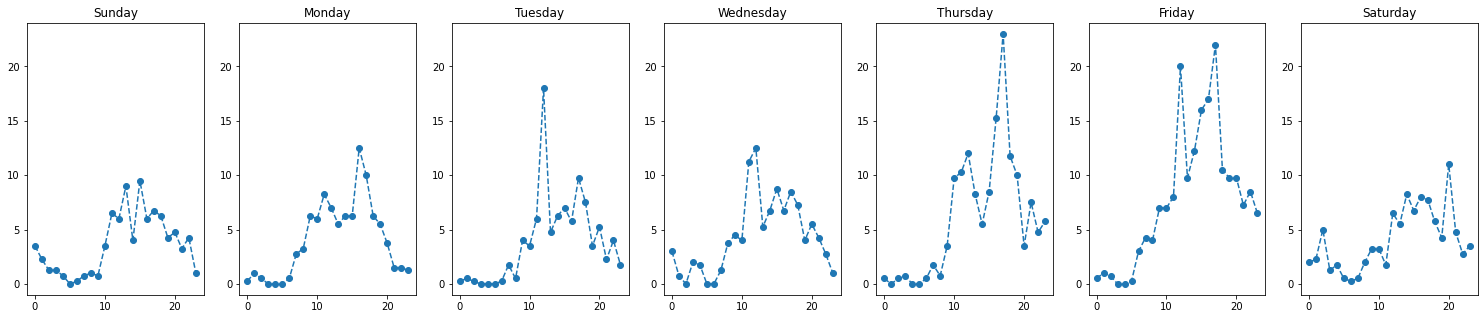

In [141]:
day_mean = [[] for i in range(7)]

for i,g in enumerate(range(7*4)):
    y = i%7
    day_mean[y].append(Y[24*(g):24*(g+1)])

    
day_mean = np.array(day_mean).mean(axis=1)

fig, ax = plt.subplots(1,7,figsize=(26,5))


for i,k in enumerate(day_mean):
    ax[i].plot(k,'o--')
    ax[i].set_title(days[i%7])
    ax[i].set_ylim(-1,1+np.max(day_mean))

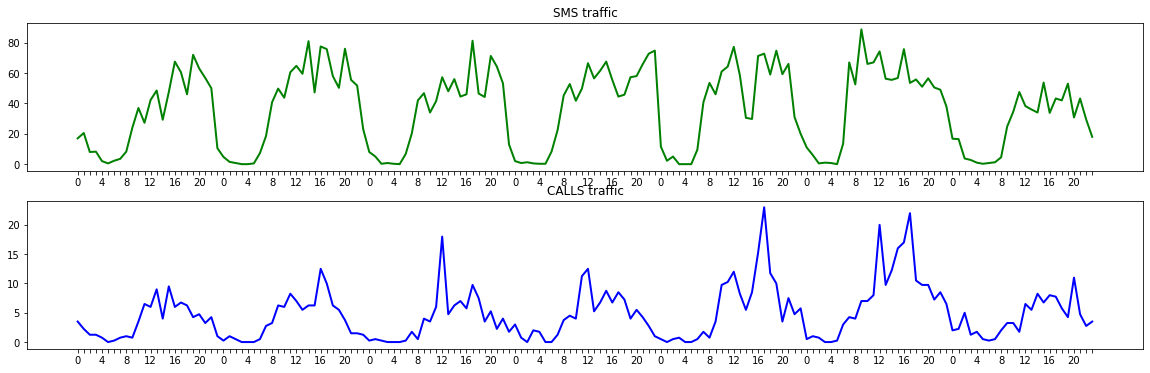

In [180]:
fig, ax = plt.subplots(2,figsize=(20,6))

x = list(range(24))*7

for i in range(len(x)):
    if i%4 == 0:
        x[i] = str(x[i])
    else:
        x[i] = ''

ax[0].plot(range(24*7),sms_traf_comp.flatten(),linewidth = 2, color= 'green')
ax[0].set_title('SMS traffic')
ax[1].plot(range(24*7),calls_traf_comp.flatten(), linewidth = 2, color = 'blue')
ax[1].set_title('CALLS traffic')


_ = ax[0].set_xticks(range(24*7),x)
_ = ax[1].set_xticks(range(24*7),x)

# COMUNITY DETECTION

In [31]:
from networkx.algorithms.community.centrality import girvan_newman

G_sms = nx.from_pandas_edgelist(sms_total,
                source='sender',target='recipient',edge_attr='weight', create_using=nx.DiGraph())


communities = girvan_newman(G_sms)

node_groups = []
for com in next(communities):
    node_groups.append(list(com))

'''color_map = []
for node in Gfacebook:
    
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('orange')  
nx.draw(Gfacebook, node_color=color_map, with_labels=True)'''

node_groups

[[0,
  3,
  4,
  5,
  6,
  11,
  12,
  13,
  14,
  15,
  19,
  23,
  25,
  27,
  28,
  29,
  31,
  36,
  37,
  39,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  54,
  55,
  56,
  58,
  59,
  61,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  72,
  73,
  74,
  75,
  76,
  81,
  85,
  88,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  99,
  100,
  104,
  105,
  106,
  108,
  109,
  111,
  112,
  116,
  118,
  119,
  120,
  121,
  122,
  126,
  128,
  129,
  131,
  133,
  136,
  137,
  139,
  140,
  141,
  143,
  144,
  145,
  146,
  147,
  149,
  151,
  152,
  154,
  155,
  157,
  158,
  165,
  166,
  167,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  182,
  183,
  185,
  186,
  187,
  188,
  190,
  191,
  192,
  193,
  194,
  195,
  197,
  200,
  203,
  204,
  205,
  207,
  208,
  210,
  211,
  213,
  215,
  217,
  218,
  219,
  221,
  222,
  224,
  225,
  227,
  229,
  234,
  235,
  236,
  237,
  239,
  240,
  244,
  246,
  249,
  250,
  252,

In [41]:

G_calls = nx.from_pandas_edgelist(calls_total,
                source='caller',target='callee', create_using=nx.DiGraph())

communities = girvan_newman(G_sms)

node_groups = []
for com in next(communities):
    node_groups.append(list(com))

'''color_map = []
for node in Gfacebook:
    
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('orange')  
nx.draw(Gfacebook, node_color=color_map, with_labels=True)'''

node_groups

[[736, 677, 421, 359, 681, 652, 111, 207, 560, 144, 634],
 [648, 243],
 [4,
  263,
  266,
  15,
  785,
  146,
  145,
  670,
  416,
  289,
  424,
  552,
  176,
  177,
  578,
  67,
  344,
  221,
  100,
  752,
  373],
 [136, 137, 650, 654],
 [784, 547],
 [672, 106, 85, 446],
 [235, 645],
 [108, 798],
 [640, 551, 172, 598, 694, 95],
 [454, 12, 13, 244, 25, 766],
 [129,
  3,
  644,
  485,
  166,
  357,
  165,
  774,
  586,
  423,
  812,
  239,
  48,
  49,
  179,
  180,
  415],
 [257, 707, 331, 140, 118, 830],
 [448, 480, 356, 422, 491, 556, 208, 274, 210, 632, 185, 285],
 [473, 636],
 [253, 692, 637, 702],
 [628, 468, 116],
 [117, 79],
 [682, 490, 330, 688, 405, 152, 797, 158, 383],
 [288, 121, 104],
 [472, 537, 126],
 [549, 799],
 [36, 37, 69, 133, 744, 743, 299, 300, 301, 237, 381],
 [554, 638],
 [791, 7],
 [68, 471],
 [561, 466, 173, 631],
 [474, 639, 703],
 [96, 290, 678, 780, 342, 470, 190],
 [706, 611, 354, 131, 358, 169, 521, 267, 268, 269, 401, 403, 280, 666, 543],
 [265, 687],
 [44